# Simulation *time parallel* d'un Broadcast

L'objectif de ce notebook python est d'illustrer le principe d'une simulation time parallel d'un code MPI à l'aide de SMPI.

Ici, nous nous intéressons à un simple série de broadcasts dont la source change à chaque itération.

Nous supposons que le code de cette simulation est dans un répertoire avec un Makefile permettant la compilation (make) et l'exécution (make run) de la simulation. L'exécution dépend des variables shell suivantes:
- NPROCS (e.g., 10 for a simulation with 10 MPI ranks)
- N: total number of iterations
- MIN: the simulation should start at iteration MIN
- MAX: the simulation should stopt at iteration MAX
- DELAY: (e.g., '0, 1.2, 0.3, ..., 0.5') by how much each MPI rank should wait before starting the execution for real
- RESULTS_TRACE: name of the Paje trace (e.g., Time_Bcast.trace)
- RESULTS_OUTPUT: name of the output file for stdout (e.g., bcast_results.txt)

La simulation parallèle est en mode master worker avec un modèle fork/join. Chaque worker simule les itérations MIN à MAX en introduisant un retard propre à chaque rank MPI et défin dans la variable DELAY. L'idée est que les trajectoires se synchronisent rapidement les unes avec les autres en raison des opérations de synchronisation internes à l'application MPI.

In [1]:
# Cosmetics for using the whole width of your screen
# https://stackoverflow.com/questions/21971449/how-do-i-increase-the-cell-width-of-the-jupyter-ipython-notebook-in-my-browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## 1. Informations générales sur l'organisation des données

La variable *experiment_name* indique le nom du folder contenant les fichiers sources et les résultats. Elle ne doit pas contenir d'espace et est principalement utilisée comme nom de répertoire dans le tmp distant pour stoquer les résultats temporaires.

La variable *crahed* indique si l'expérience a été interrompue et s'il est possible de sauter l'étape d'installation de simgrid, pj_dump, etc.

In [2]:
experiment_name = "Time_Bcast"
crashed = True

#### Paths (to configure)
These variables are global to the whole notebook and should not be modified afterward.

In [3]:
path_local = "/home/alegrand/Work/Journals/najwa_ez-zine/SimGrid/examples/SMPI/Time_Bcast/" 
# This is the location of the source of the code you want to simulate
path_local_src = path_local + "src/" 
# This is where all the traces and results will be gathered
path_local_results = path_local + "results_new/" 

# This is the remote location where the source code will be copied, compiled and run
# You may want to postfix it by the current date or whatever you want in experiment_name
path_remote = "/tmp/" + experiment_name + "/"
path_remote_src = path_remote + "src/" 
path_remote_results = path_remote + "results/"

# naming conventions: these files will be generated when simulating (make run) and used for the analysis
trajectory_output = "output.txt"
trajectory_trace  = "output.trace"

#### Naming convention

An parallel simulation is called an *experiment* and is identified by an *experiment_id* (a more or less readable name). It involves running many (sequential) simulations with different parameters, which we call *trajectories* and are identified by a *trajectory_id* (a SHA1 of the parameters). The gen_experiment_id function is just for your convenience as experiment_id can be manually set and will be used to organize files in a more readable way.
However trajectory_id will be automatically encoded with our SHA1 conventions.

In [4]:
import datetime
def gen_experiment_id():
    return datetime.datetime.now().strftime('%Y-%m-%d_%H-%M') # Use '-' and not ':' in 'H:M' as ':' is a pain in filenames on Windows

test_experiment_id = gen_experiment_id() # This variable, like the trajectory variables will be dynamically generated
print(test_experiment_id)

2018-11-22_01-32


In [5]:
import hashlib

# Formate le tableau en string pour pouvoir etre passé en ligne de commande
def format_cmd(data):
    return (' '.join(str(e) for e in data))

# Formate le string en tableau d'int pour être manipulé 
def unformat_cmd(data):
    return list(map(float, data.split()))
    
def get_trajectory_id(MIN,D):
    return hashlib.sha1((str(MIN) + format_cmd(D)).encode('utf-8')).hexdigest()


# Example:
# get_trajectory_id(20,[.3,.2,.5,0.3,.2])

def get_path_remote_results(xp_id,traj_id):
    return path_remote_results + xp_id + '/' + traj_id + '/' 

def get_path_local_results(xp_id,traj_id):
    return path_local_results + xp_id + '/' + traj_id + '/' 

print(get_path_local_results(test_experiment_id,""))
print(get_path_remote_results(test_experiment_id,""))

/home/alegrand/Work/Journals/najwa_ez-zine/SimGrid/examples/SMPI/Time_Bcast/results_new/2018-11-22_01-32//
/tmp/Time_Bcast/results/2018-11-22_01-32//


Locally the file hierarchy will thus be:
- path_local_results/experiment_id/trajectory_id/trajectory_output 
- path_local_results/experiment_id/trajectory_id/trajectory_trace

Remotely, the file hierarchy will thus be:
- path_remote_results/experiment_id/trajectory_id/trajectory_output
- path_remote_results/experiment_id/trajectory_id/trajectory_trace


#### Versions

In [6]:
%%bash -s
git log -n 1
python3 --version
R --version

commit 5f7a173febdfb324aae4f4b9ba0930b855df4c23
Author: Arnaud Legrand <arnaud.legrand@imag.fr>
Date:   Wed Nov 21 09:23:54 2018 +0100

    Many cleanups in the jupyter noterbook, the SMPI simulation file and the Makefile.
    
    Visualisation is broken but at least there is no more hardcoded path,
    file naming conventions are better and this allows for a local
    execution.
Python 3.6.6
R version 3.5.1 (2018-07-02) -- "Feather Spray"
Copyright (C) 2018 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under the terms of the
GNU General Public License versions 2 or 3.
For more information about these matters see
http://www.gnu.org/licenses/.



## 2. Préparation de l'environnement (FRONTEND)

#### Installation des modules

In [9]:
%%bash -s
pip3 install --user execo
pip3 install --user requests

# Permet affichage pllus lisible avec couleurs
pip3 install --user termcolor

# Permettent d'utiliser R :
pip3 install --user rpy2
pip3 install --user tzlocal

  Using cached https://files.pythonhosted.org/packages/ff/17/5cbb026005115301a8fb2f9b0e3e8d32313142fe8b617070e7baad20554f/requests-2.20.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/62/00/ee1d7de624db8ba7090d1226aebefab96a2c71cd5cfa7629d6ad3f61b79e/urllib3-1.24.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/56/9d/1d02dd80bc4cd955f98980f28c5ee2200e1209292d5f9e9cc8d030d18655/certifi-2018.10.15-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/bc/a9/01ffebfb562e4274b6487b4bb1ddec7ca55ec7510b22e4c51f14098443b8/chardet-3.0.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/4b/2a/0276479a4b3caeb8a8c1af2f8e4355746a97fab05a372e4a2c6a6b876165/idna-2.7-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/7f/ff/ae64bacdfc95f27a016a7bed8e8686763ba4d277a78ca76f32659220a731/Jinja2-2.10-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/67

#### Chargement des modules dans l'environnement

In [7]:
import execo
import math
import collections
import os
import sys
import json
import time
import random
import datetime
import re
import tzlocal

from execo import *
from execo_g5k import *
from execo_engine import *

from shutil import copy
from subprocess import check_output

from threading import Thread

from collections import deque, OrderedDict
from termcolor import *
from subprocess import *

#### Chargement de l'outil permettant l'utilisation de R

In [8]:
%load_ext rpy2.ipython

In [9]:
%%R
#install.packages('ggplot2')
#install.packages('dplyr')
#install.packages('tidyr')

NULL


In [10]:
%%R
library(dplyr)
library(tidyr)
library(ggplot2)
sessionInfo()
devtools::session_info()

/home/alegrand/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
Attachement du package : ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/home/alegrand/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/home/alegrand/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)
/home/alegrand/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Need help? Try Stackoverflow: https://stackoverflow.com/tags/ggplot2.

  warnings.warn(x, RRuntimeWarning)
/home/alegrand/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Session info -----------------------------------------------------------------

 setting  value                       
 version  R version 3.5.1 (2018-07-02)
 system   x86_64, linux-gnu           
 ui       X11                         
 language (EN)                        
 collate  fr_FR.UTF-8                 
 tz       Europe/Paris                
 date     2018-11-22                  

 package    * version date       source        
 assertthat   0.2.0   2017-04-11 CRAN (R 3.5.0)
 base       * 3.5.1   2018-07-02 local         
 bindr        0.1.1   2018-03-13 CRAN (R 3.5.0)
 bindrcpp     0.2.2   2018-03-29 CRAN (R 3.5.0)
 colorspace   1.3-2   2016-12-14 CRAN (R 3.5.0)
 compiler     3.5.1   2018-07-02 local         
 datasets   * 3.5.1   2018-07-02 local         
 devtools     1.13.6  2018-06-27 CRAN (R 3.5.1)
 digest       0.6.15  2018-01-28 CRAN (R 3.5.0)
 dplyr      * 0.7.6   2018-06-29 CRAN (R 3.5.1)
 ggplot2    * 3.0.0   2018-07-03 CRAN (R 3.5.1)
 glue         1.2.0   2017-10-29 CRAN (R 3.5.0)
 graphics   * 3.5.1   2018-07-02 local         
 grDevices  * 3

### Tools

#### Affichage coloré

In [11]:
# Termcolor
# COLORS : grey red green yellow blue magenta cyan white
# HIGHLIGHTS : on_grey on_red on_green on_yellow on_blue on_magenta on_cyan on_white
# OPTIONS  : bold, dark, underline, blink, reverse, concealed

text = colored('Hello, World!', 'red', attrs = ['blink'])
print(text)

text = colored('Hello, World!', 'blue', attrs = ['dark'])
print(text)

text = colored('Hello, World!', 'red', attrs = ['underline'])
print(text)

text = colored('Hello, World!', 'red', attrs = ['bold'])
print(text)

text = colored('Hello, World!', 'cyan', attrs = ['concealed'])
print(text)

cprint('Hello, World!', 'yellow', 'on_red',attrs = ['reverse'])

Hello, World!
Hello, World!
Hello, World!
Hello, World!
Hello, World!
Hello, World!


#### Affichage lisible d'un dictionnaire complexe

In [12]:
# Display more readable dict
# SOURCE : https://stackoverflow.com/questions/3229419/how-to-pretty-print-nested-dictionaries
def hash_pretty_print(d, indent = 0):
    for key, value in d.items():
        print('\t' * indent + colored (str(key), "magenta"))
        if isinstance(value, type({})):
            hash_pretty_print(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))

In [13]:
%%R
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

## 3. Préparation de l'environnement pour l'expérience (remote)

## Option 1: Exécution en local

In [14]:
nodes=["localhost","localhost","localhost","localhost"]
nodecount = len(nodes)
user = "alegrand"
Remote_test = execo.action.Remote(cmd = 'ls',hosts = nodes, connection_params = None, process_args = None)
Remote_test.run().ok

True

Assurez vous que vous avez bien installé SimGrid et pajeng. Une des cellules plus loin est dédiée à la récupération des numéros de version de ces outils. Si vous ne savez pas comment les installer, regardez les commandes dans l'Option 2 ci dessous.

## Option 2: Réservation sur Grid 5000

In [16]:
# Nom du job
jobname = ' '
# Nombre de noeuds
nodecount = 5
# Temps réservation
walltime = "2:0:0" 
# Username distant
user = "root"

# filters out Nantes's econome cluster
resources_selection = " -p \"cluster in ('ecotype','parasilo','griffon','grisou','uvb','paravance','genepi')\"" 

# Nancy
site = "nancy"

#Type de deploiement 
FILE_DEPLOY = True

#### Réservation

In [17]:
jobs = get_current_oar_jobs()
jobid = None
waiting_jobs = []
while jobs:
    j, site = jobs.pop()
    info = get_oar_job_info(j, site)
    if info['name'] == jobname:
        if info['state'] == 'Running':
            jobid = j
            print("A {} job is already running, using it. jobid is {}".format(jobname, jobid))
            break
        else:
            waiting_jobs.append(j)
if not jobid and not waiting_jobs:
    jobspec = OarSubmission(resources="/cluster=1/nodes={}".format(nodecount), walltime = walltime,
                            additional_options = resources_selection, job_type = "deploy", name = jobname)
    jobid, _ = oarsub([(jobspec, site)]).pop()
    print("New job submitted, jobid is {}".format(jobid))
elif not jobid:
    print("One or more {} jobs exist ({}) but are not running.\n"
          " Connect to the frontend to see what is happening, and/or run the cell again.".format(
          jobname, ", ".join([str(j) for j in waiting_jobs])))

A   job is already running, using it. jobid is 1621284


#### Récupération des infos sur les noeuds obtenus

###### Note : Si cette cellule met du temps à répondre, vérifier l'état de la réservation sur la frontale **oartstat -u username** ou via https://www.grid5000.fr/mediawiki/index.php/Status

In [18]:
nodecount = 4
nodes = get_oar_job_nodes(jobid)
nodes.sort(key = lambda n: n.address)
del nodes[3]
nodes

[Host('griffon-18.nancy.grid5000.fr'),
 Host('griffon-19.nancy.grid5000.fr'),
 Host('griffon-24.nancy.grid5000.fr'),
 Host('griffon-26.nancy.grid5000.fr')]

##### Déploiement de l'environnement : 2 options

###### Option 1: Via fichier 

In [19]:
force_redeploy = False # set to True to force redeploying the OS on the nodes in the deployment section
environment_dsc_file = 'src/debian9-x64-bigdata-tutorial.yaml' # filename of the kadeploy environment file (YAML)

In [20]:
if (FILE_DEPLOY):
    deployment = Deployment(hosts = nodes, env_file = os.path.abspath(environment_dsc_file),
                            other_options = "-r ext4 --no-debug-mode")

    deploy_ok, deploy_failed = deploy(deployment, check_deployed_command = not force_redeploy,
                                      stdout_handlers = [sys.stdout],
                                      stderr_handlers = [sys.stderr])
else :
    deploy_ok, deploy_failed = deploy(Deployment(nodes, env_name = "debian9-x64-base",
                                                  other_options = "-r ext4 --no-debug-mode"),
                                        stdout_handlers = [sys.stdout],
                                        stderr_handlers = [sys.stderr])

In [21]:
print("Deployement status:\n* ok: {}\n* failed: {}".format(deploy_ok, deploy_failed))

Deployement status:
* ok: {'griffon-19.nancy.grid5000.fr', 'griffon-18.nancy.grid5000.fr', 'griffon-26.nancy.grid5000.fr', 'griffon-24.nancy.grid5000.fr'}
* failed: set()


#### Test : commande simple 'ls'

In [15]:
Remote_test = execo.action.Remote(cmd = 'ls',hosts = nodes, connection_params = None, process_args = None)
Remote_test.run().ok

True

#### Installation environnement/tools sur noeuds

In [23]:
if (not crashed):
    Remote_install = execo.action.Remote(cmd = 'apt-get install g++ libboost-all-dev',
                                         hosts = nodes,
                                         connection_params = {'user':'root'})
    Remote_install.run().ok

In [24]:
if (not crashed):
    Simgrid_install = execo.action.Remote(cmd = 'cd ~/SimGrid-3.18 && cmake -DCMAKE_INSTALL_PREFIX=/usr/local -Denable_smpi=on -Denable_documentation=off',
                                         hosts = nodes[3],
                                         connection_params = {'user':'root'})
    Simgrid_install.run().ok

In [25]:
if (not crashed):
    Simgrid_install = execo.action.Remote(cmd = 'cd ~/SimGrid-3.18 && make -j && make install -j',
                                         hosts = nodes[3],
                                         connection_params = {'user':'root'})
    Simgrid_install.run().ok

In [26]:
if (not crashed):
    Pajeng_install = execo.action.Remote(cmd = 'git clone git://github.com/schnorr/pajeng.git ; mkdir -p pajeng/build ; cd pajeng/build ; cmake .. ; make ; make install',
                                         hosts = nodes,
                                         connection_params = {'user':'root'}
                                        ).run().ok
    Pajeng_install

## 4. Vérification de la version des logiciels nécessaires à la simulation Simgrid (remote)

In [16]:
def remote_version(software):
    execo.action.Remote(cmd = 'touch version.txt &&' + str(software) + ' --version > version.txt', 
                        hosts = nodes, 
                        connection_params = {'user': user}
                       ).run()

    version = ''

    for i in range(nodecount):
        execo.action.Get(hosts = nodes[i], remote_files = ['~/version.txt'],
                         local_location = './version-'
                                            + get_host_shortname(nodes[i]) + '.txt',
                         connection_params = {'user': user}).run()
    
        version = version + execo.Process(cmd = 'cat ./version-'
                                                + get_host_shortname(nodes[i]) 
                                                + '.txt').run().stdout
        execo.Process(cmd = 'rm ./version-'
                            + get_host_shortname(nodes[i]) + '.txt').run()

    print(colored('VERSION : ' + str(software),"blue"), '\n' + version + '\n')
    return

remote_version('smpicc')
remote_version('g++')
remote_version('pj_dump')

VERSION : smpicc 
SimGrid version 3.21.90-DEVEL
SimGrid version 3.21.90-DEVEL
SimGrid version 3.21.90-DEVEL
SimGrid version 3.21.90-DEVEL


VERSION : g++ 
g++ (Debian 6.4.0-12) 6.4.0 20180123
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

g++ (Debian 6.4.0-12) 6.4.0 20180123
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

g++ (Debian 6.4.0-12) 6.4.0 20180123
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

g++ (Debian 6.4.0-12) 6.4.0 20180123
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for

## 5. Simulation

#### Traitement des données pour les calculs de D et S
Mostly helper functions. Only the *parse_trajectory_delay* function is used in the simulation. 

In [17]:
# Initialise tableau
def init_tab(num, elt) :
    D = [elt] * num
    return D

# Parsing the results (output) of a trajectory
def parser(xp_id, traj_id):
    with open( get_path_local_results(xp_id,traj_id) + trajectory_output) as f:
        return f.readlines()
    
# Converting and organizing data
def tab_conv(l, NPROCS, precision) :
    S = init_tab(NPROCS, None)
        
    # On récupère les données des fichiers
    # Un fichier contient des lignes telles que : From 0 -> 0.0819526    
    for i in range(0, NPROCS) :
        if(re.match(r"^From \d+ -> [\d\.e\+]+$", l[i])):
            continue
        line = l[i].split()
        S[int(line[1])] = round(float(line[3]), precision)
    return S

def parse_trajectory_delay(NPROCS, xp_id, traj_id, precision):
    D = init_tab(NPROCS, 0.0)
    
    raw_data = parser(xp_id, traj_id)
    
    S = tab_conv(raw_data, NPROCS, precision)
    
    for p in range(0, NPROCS):
        D[p] = round(S[p] - min(S), precision)
    return [D, min(S)]

In [18]:
# Example
# parse_trajectory_delay(0,10,'2018-06-04_12:38',"0208ceee1447188923ebfc46ec7d99aed6e8f2ba",2)

#### Mise en place de l'environnement (fichiers src simulation...) sur noeuds

In [19]:
def env_setup(id):
    os.system("mkdir -p "+get_path_local_results(id,""))
    Src_Rslt_dir = execo.action.Remote(cmd = 'mkdir -p ' + path_remote_src + ' && '
                                        'mkdir -p ' + get_path_remote_results(id,""),
                                  hosts = list(set(nodes)),
                                  connection_params = {'user': user})
    Src_get = execo.action.Put(hosts = list(set(nodes)),
                               local_files = [path_local_src + '/*'],
                                remote_location = path_remote_src,
                                connection_params = {'user': user})
    Src_compile = execo.action.Remote(cmd ='cd '+path_remote_src+ ' && make',
                                  hosts = list(set(nodes)),
                                  connection_params = {'user': user})
    if not (Src_Rslt_dir.run().ok 
            and Src_get.run().ok
            and Src_compile.run().ok):
        raise Error("Environnement could not be set : Check files")

# Example:
# env_setup("2018-11-20_23-01")

#### Définition du thread pour parallélisation de la simulation

In [20]:
# Thread pour la simulation // opt.
class ParSimer(Thread):

    """Thread chargé simplement d'afficher une lettre dans la console."""
    
    # Paramètrage du thread
    def __init__(self, host_id, xp_id, NPROCS, N, MIN, MAX, DELAY):
        Thread.__init__(self)
        self.NPROCS = NPROCS
        self.N = N
        self.MIN = MIN
        self.MAX = MAX
        self.DELAY = DELAY
        self.host_id = host_id
        self.xp_id = xp_id
    
    def get_delay(self):
        return self.DELAY
    
    def get_MIN(self):
        return self.MIN
    
    def run(self):
        """Code à exécuter pendant l'exécution du thread."""
        if (DEBUG): 
            print(
                colored(get_host_shortname(nodes[self.host_id]), "grey", "on_blue", attrs = ['reverse']) 
                + " => NPROCS = " + str(self.NPROCS)
                + " N = " + str(self.N)
                + colored(" MIN = ", "cyan") + str(self.MIN)
                + colored(" MAX = ", "red") + str(self.MAX)
                + " DELAY = '" + self.DELAY
            )
       
        # make run sur la machine dont le thread s'occupe avec ses paramètres
        xp_id = self.xp_id
        traj_id = get_trajectory_id(MIN=self.MIN,D=self.DELAY)
        cmd = ('cd '+ path_remote_src + ' && make run ' +
                ' NPROCS='+ str(self.NPROCS) + 
                ' N=' + str(self.N) +
                ' MIN='+ str(self.MIN)  +
                ' MAX=' + str(self.MAX) + 
                " DELAY='" + self.DELAY + "'" +
                " RESULTS_TRACE=" + get_path_remote_results(xp_id,traj_id) + trajectory_trace +
                " RESULTS_OUTPUT=" + get_path_remote_results(xp_id,traj_id) + trajectory_output)
        if (DEBUG): 
            print("\t"+cmd)
        if not(execo.action.Remote(cmd = cmd, hosts = nodes[self.host_id], 
                            connection_params = {'user':user}).run().ok):
            raise NameError("Simulation failed on "+nodes[self.host_id]+". Check "+path_remote_src+" and "+get_path_remote_results(xp_id,traj_id))

#### Génération du nouvel état initial

In [21]:
smart_table = {}

def reset_smart_table():
    smart_table = OrderedDict()
    return

#### FIXME: NPROCS should be a parameter
def update_smart_table(final_state, t):
    final_state = unformat_cmd(final_state)
    smart_table.setdefault(t, [final_state,2])
    nb_val = smart_table[t][1]
    
    
    for i in range(NPROCS):
        smart_table[t][0][i] = (smart_table[t][0][i] * (nb_val - 1) + final_state[i]) / nb_val    
        
    smart_table[t][1] +=1

def generate_Dprime(NPROCS, border_inf, border_sup, precision):
    # Variable pour le stockage du nouveau D
    new_Dprime = []

    for p in range(NPROCS):
        random_value = random.uniform(border_inf[p], border_sup[p])
        round_value = round(random_value, precision)
        new_Dprime.append(round_value)
    return format_cmd(new_Dprime)

#### FIXME: NPROCS should be a parameter
def generate_initial_state(mode, final_state, t):
    borders = unformat_cmd(final_state)
    # S'il n'y a pas de limite supérieure, on limite au double de l'état final obtenu
    double_Dprime = [(2 * (x)) for x in borders]
                      
    # Bornes pour le random 
    border_inf = init_tab(NPROCS, 0.0)
    border_sup = double_Dprime
    if (mode == "RAND_SUP") : 
        border_sup = borders
        new_initial_state =  generate_Dprime(NPROCS, border_inf, border_sup, precision)
    elif (mode == "RAND_INF") : 
        border_inf = borders
        new_initial_state = generate_Dprime(NPROCS, border_inf, border_sup, precision)
    elif (mode == "RAND") : 
        new_initial_state =  generate_Dprime(NPROCS, border_inf, border_sup, precision)
    elif (mode == "SMART_GUESS"):
        update_smart_table(final_state, t)
        new_initial_state = format_cmd(smart_table[t][0])
    return new_initial_state

#### Fonctions pour la simulation

In [22]:
def get_results(xp_id, traj_id, host_id):
    os.system("mkdir -p "+get_path_local_results(xp_id,traj_id))
    execo.action.Get(
            hosts = nodes[host_id],
            remote_files = [get_path_remote_results(xp_id,traj_id) + trajectory_output],
            local_location = get_path_local_results(xp_id,traj_id) + trajectory_output,
            connection_params = {'user': user}).run().ok

def pj_dump(xp_id, traj_id, host_id):
        path = get_path_remote_results(xp_id,traj_id)
        execo.action.Remote(
            cmd = 'pj_dump --ignore-incomplete-links '+path+trajectory_trace+' > '+path+'output.csv',
            hosts = nodes[host_id],
            connection_params = {'user':user}
        ).run()

        execo.action.Remote(
            cmd = 'grep State '+path+'output.csv > '+path+'output.state.csv',
            hosts = nodes[host_id],
            connection_params = {'user': user}
        ).run()
        execo.action.Remote(
            cmd = 'grep Link '+path+'output.csv > '+path+'output.link.csv',
            hosts = nodes[host_id],
            connection_params = {'user': user}
        ).run()
        execo.action.Remote(
            cmd = 'rm '+path+'output.csv',
            hosts = nodes[host_id],
            connection_params = {'user': user}
        ).run()
        return
        
def get_csv(xp_id, traj_id, host_id):
        path = get_path_remote_results(xp_id,traj_id)
        execo.action.Get(
            hosts = nodes[host_id],
            remote_files = [get_path_remote_results(xp_id,traj_id)+'*.csv'],
            local_location = get_path_local_results(xp_id,traj_id),
            connection_params = {'user': user}
        ).run()
        
def draw_ggplot(path_base, MIN, MAX, D, merging, t_curr):
            %R library(ggplot2)
            %R -i path_base
            %R -i MIN 
            %R -i MAX
            %R -i D
            %R -i merging
            %R -i t_curr
            %R result = c()
            %R if(merging || t_curr > MIN) {palette = "Set1"} else {palette = "Pastel1"}
            %R df_state = read.csv(paste(path_base, "/output.state.csv",sep = ""), header = F, strip.white=T)
            %R names(df_state) = c("Type", "Rank", "Container", "Start", "End", "Duration", "Level", "State"); 
            %R df_state = df_state[!(names(df_state) %in% c("Type","Container","Level"))]
            %R df_state$Rank = as.numeric(gsub("rank-","",df_state$Rank))
            %R gc = ggplot(data=df_state) + geom_rect(aes(xmin=Start, xmax=End, ymin=Rank, ymax=Rank+1,fill=State)) + scale_fill_brewer(palette = palette)
            %R df_link = read.csv(paste(path_base, "/output.link.csv",sep = ""), header = F, strip.white = T)
            %R names(df_link) = c("Type", "Level", "Container", "Start", "End", "Duration", "CommType", "Src", "Dst"); 
            %R df_link = df_link[!(names(df_link) %in% c("Type","Container","Level","CommType"))]
            %R df_link$Src = as.numeric(gsub("rank-","",df_link$Src))
            %R df_link$Dst = as.numeric(gsub("rank-","",df_link$Dst))
#             %R step = round((max(df_link$End)/7),5)
            %R step = 0.0025
            %R result = gc + geom_segment(data = df_link, aes(x = Start, y = Src, xend = End, yend = Dst),arrow = arrow(length = unit(0.01, "npc"))) + scale_x_continuous(breaks = seq(0, 0.02, by = step)) + ggtitle(paste('Zone : ' , MIN, ' - ', MAX, '\nPour D', D) )
            %R print(result)

In [23]:
def state_match(sim, t_curr, D_curr, gap, NPROCS):
    merging = True
    number_of_keys = len(sim[t_curr])
        
    for index in range(number_of_keys):
        D = list(sim[t_curr].keys())[index]
        D = unformat_cmd(D)
        if type(D_curr) is str : 
            D_curr = unformat_cmd(D_curr)
            
        merging = all(math.isclose(D_curr[i], D[i], abs_tol = gap) for i in range(NPROCS))
        if (merging) : 
            D = format_cmd(D) ; 
            print("merging : " + str(D)); 
            return merging , D
        
    D_curr = format_cmd(D_curr)
    return  merging , D_curr

#### Code de la simulation

In [24]:
# SIMULATION
import warnings
warnings.filterwarnings("ignore")
def simulation(N, NPROCS, fragment_size, precision, mode, gap, catch_me):
    
    """Contrôle de la validité des paramètres"""
    # Taille du fragment ne peut être supérieure à la zone d'itération
    if (fragment_size > N): 
        raise ValueError("Fragment size cannot be superior to N")
        
    """Mise en place de l'environnement et des variables"""
    # Environnement
    experiment_id = gen_experiment_id()
    print("Setting up environment for " + experiment_id)
    env_setup(experiment_id) 
    
    F = open(get_path_local_results(experiment_id,"")+"/simulation_config.txt","w")
    F.write('NPROCS ='+ str(NPROCS))
    F.write('N ='+ str(N))
    F.write('fragment_size ='+ str(fragment_size))
    F.write('precision ='+ str(precision))
    F.write('mode ='+ str(mode))
    F.write('gap ='+ str(gap))
    F.close()
    
    # Temps d'exécution total
    total_execution_time = 0
    
    # Tableau de threads
    machines = init_tab(nodecount, None)
      
    # position trajectoire cohérente courante
    t_curr = 0
    
    # D de la trajectorie cohérente courante
    D_curr = format_cmd( init_tab( NPROCS, 0.0))

    fragment_number = int((math.ceil(N / fragment_size)))
    
    # zone d'itérations à explorer
    To_explore = collections.deque()
    
    # Initialisation des zones à explorer D = '0...0' pour chaque zone T -> (Min d'itération , D initial)
    for i in range(fragment_number):
        To_explore.append((i * fragment_size, format_cmd(init_tab(NPROCS, 0.0))))

    # Round actuel
    curr_round = 0
    
    # Liste des trajectoires pour un temps t et un D donnée
    sim = OrderedDict()
    
    # Vrai si un état final a fusionné avec un état initial au moins une fois
    success = False 
    
    if (mode == "SMART_GUESS"): reset_smart_table()
    
    catch_me_ind = 0
        
    while(True):
        curr_round = curr_round + 1
        
        # Zones restantes à explorer
        number_paths_To_explore = len(To_explore)
        # Trajectoire cohérente complète trouvé : FIN DE SIMULATION
        if (t_curr >= N) :
            cprint ("Total time : " + str(total_execution_time) , "grey" , "on_yellow")
            cprint ("Success : " + str(success) , "grey" , "on_green")
            cprint ("Efficiency (Rounds) ->  // : " + str(curr_round) + "|  Sequential : " + str(fragment_number) + " Total : " + str((1-curr_round/fragment_number)*100), "white", "on_magenta")
            break;        
        if (number_paths_To_explore  == 0):
            raise "No path to explore left !"
        # Il n'existe pas encore de trajectoire cohérente -> Nouveau round
        cprint("--------------------------------------------  ROUND :  " + str(curr_round) + "   --------------------------------------------\n","red", attrs=['reverse', 'blink'])
        

        
        # Nombre de tâches parallèles lançables
        number_launchable_tasks = min(nodecount, number_paths_To_explore)
        
        # Affichage des paramètres
        cprint ("  || LAUNCHING || \n","green", attrs=[ 'reverse', 'blink'])
        if (DEBUG): 
            cprint ( "TO EXPLORE : " , "blue")
            for key, value in (To_explore):
                print( colored( str(key), "green") + ' -> ' + str(value))
            print("")
        
        """ Paramètrage des machines """
        
        # Soit j'ai plus de zone à explorer que de machines disponibles soit l'inverse
        for q in range(number_launchable_tasks):
            
            # On récupère la première zone à explorer
            parameters = To_explore.popleft()
            
            # MIN est le champ de gauche
            MIN = parameters[0]
            
            # MAX de la zone à explorer vaut le min + la taille du slot
            MAX = min (MIN + fragment_size, N)
            
            # D est le champ de droite
            delay = parameters[1]
            
            # Paramètrage des machines
            machines[q] = ParSimer(host_id=q, xp_id=experiment_id, NPROCS=NPROCS, N=N, MIN=MIN, MAX=MAX, DELAY=delay)
            #print("Machine " + str(q) + " -> MIN :" + str(MIN) + " MAX : " + str(MAX) + " D : "+ delay)   
                
        """ Simulation """  
        # Lancement de la simulation
        for q in range(number_launchable_tasks):
            machines[q].start()
            
        # Fin de simulation
        for q in range(number_launchable_tasks) :
            machines[q].join()
            MIN = machines[q].get_MIN()
            D = machines[q].get_delay()
            get_results(host_id=q,xp_id=experiment_id,traj_id=get_trajectory_id(MIN,D))
            
          
        """ Analyse des résultats"""    
        # Traitement des données
        for q in range(number_launchable_tasks):
            # On récupère les paramètres des machines
            t = machines[q].get_MIN()
            D = machines[q].get_delay()
            
            # Calcul du délai
            # On récupère D et S
            raw_data = parse_trajectory_delay(NPROCS, experiment_id, get_trajectory_id(t,D), precision)
            
            # Filtre D : Calcul du délai
            Dprime = format_cmd(raw_data[0])
            
            #Filte S : Calcul du temps d'éxécution total 
            T = raw_data[1]
            
            # Ajout dans ma table (Dprime, round, machine qui l'a calculé, temps)
            sim.setdefault(t,{}).update({D:(Dprime,curr_round,q,T)})
            # MAX = min (t + fragment_size, N)
        
        # Affichage des paramètres
        print ( colored ("T_curr : " , "yellow") , str(t_curr))
        if (DEBUG) :
            print ( colored ("D_curr : " , "yellow") , str(D_curr))
            print ( colored ("Dprime : ", "yellow") , str(Dprime))
        print ( colored ("total execution time : ", "red") , str(total_execution_time) + "\n") 
        
        merged_paths = 0
        # Calcul de la trajectoire cohérente
        if(t_curr in sim) :
            merging , D_curr = state_match(sim, t_curr, D_curr, gap, NPROCS)
        while (t_curr < N and t_curr in sim and merging):
            #D_curr in sim[t_curr]):
            merged_paths += 1
            # Update le temps d'exécution
            total_execution_time += sim[t_curr][D_curr][3]
            
            # Update du temps d'exécution dans le dernier fragment
            if (t_curr + fragment_size >= N) : total_execution_time += max(unformat_cmd(sim[t_curr][D_curr][0]))
            
            # Update des t_curr et D_curr
            D_curr = sim[t_curr][D_curr][0]
            t_curr = min(t_curr + fragment_size, N)
            if (t_curr in sim):
                merging , D_curr = state_match(sim, t_curr, D_curr, gap, NPROCS)
        if (merged_paths > 1) : 
            cprint("****** SUCCESS : " + str(merged_paths), attrs=['reverse', 'bold'])
            success = True 
        
        # Affichage des résultats
        cprint ("\n  || RESULTS || \n","red", attrs=[ 'reverse', 'blink'])
        if (DEBUG):
            cprint ( "TO EXPLORE : " , "blue")
            for key, value in (To_explore):
                print( colored( str(key), "green") + ' -> ' + str(value)) 
            hash_pretty_print(sim) 
        print ( colored ("T_curr : " , "yellow", attrs=[ 'bold']), str(t_curr))
        
        if (DEBUG):
            print ( colored ("D_curr : " , "yellow", attrs=[ 'bold']), str(D_curr))
            print ( colored ("Dprime : ", "yellow", attrs=[ 'bold']) , str(Dprime))
            
        print ( colored ("total execution time : ", "red", attrs=[ 'bold']) , str(total_execution_time) + "\n") 
        
        
        """ Nouveau paramètres """
        cprint("  || ANALYSIS || \n","magenta", attrs=[ 'reverse', 'blink'])
        while (To_explore and To_explore[0][0] <= t_curr):
            To_explore.popleft()
        
        for q in reversed(range(number_launchable_tasks)):
            t = machines[q].get_MIN()
            D = machines[q].get_delay()
            
            MAX = min(t + fragment_size, N)
            Dprime = sim[t][D][0]
            
            ##### This is how we would include visualization on the fly
#            pj_dump(date, filename, q)
#            get_csv(date_precise, q, curr_round, t)
#            draw_ggplot(t, MAX , D, merging, t_curr)           
           
            # Zone valide
            if(MAX < N):
                # Zone pas encore relié à la trajectoire initiale
                if (MAX > t_curr):
                    caught = False
                # Ajout dans les zones à explorer du nouveau point de départ à exploiter en fonction du mode
                    # Test catch me sur 2^catch_me_ind round
                    if (catch_me and 1 << catch_me_ind == curr_round):
                        catch_me_ind += 1
                        try :
                            caught = Dprime in sim[MAX]
                        except KeyError:
                            pass 
                       
                    if ((not catch_me or not caught) and mode != 'FIX'):
                        Dprime = generate_initial_state(mode, Dprime, t)
                        if (DEBUG) : print("["+str(MAX) +"] Generated " + str(mode) + " Dprime : " + str(Dprime))
                    # Mode fix implicite : append sans modification des valeurs MAX et Dprime    
                    To_explore.appendleft((MAX, Dprime))
        
        if (t_curr != N):
            To_explore.appendleft((t_curr, D_curr))
        if (DEBUG):
            cprint ( "TO EXPLORE : " , "blue")
            for key, value in (To_explore):
                print( colored( str(key), "green") + ' -> ' + str(value))
    return(experiment_id,sim)

## SIMULATION

In [25]:
DEBUG = True
# Nbr pcs
NPROCS = 7
    
# Nbr itérations
N = 100

# taille paquet d'itérations
fragment_size = 5

# Precision d'affichage
precision = 4

# Précision recollement trajectoire
gap = 0.0005

# mode de génération de l'état initial à chaque round
mode_opt = ["FIX", "RAND", "RAND_INF", "RAND_SUP","SMART_GUESS","SMART_BORDERS"]
mode = mode_opt[0]

catch_me = False

# Lancement de la simulation
(experiment_id,trajectory_set) = simulation(N, NPROCS, fragment_size, precision, mode, gap, catch_me)

Setting up environment for 2018-11-22_01-33
--------------------------------------------  ROUND :  1   --------------------------------------------

  || LAUNCHING || 

TO EXPLORE : 
0 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
5 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
10 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
15 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
20 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
25 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
30 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
35 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
40 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
45 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
50 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
55 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
60 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
65 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
70 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
75 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
80 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
95 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0

localhost => NPROCS = 7 N = 100 MIN = 0 MAX = 5 DELAY = '0.0 0.0 0.0 0.0 0.0 0.0 0.0
	cd /tmp/Time_Bcast/src/ && make run  NPROCS=7 N=100 

T_curr :  5
D_curr :  0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019
Dprime :  0.0036 0.0044 0.0044 0.0 0.0014 0.0022 0.003
total execution time :  0.0044

merging : 0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019

  || RESULTS || 

TO EXPLORE : 
20 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
25 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
30 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
35 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
40 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
45 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
50 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
55 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
60 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
65 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
70 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
75 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
80 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
95 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019', 1, 0, 0.0044)
5
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0035 0.0035 0.0 0.0013 0.0019 0.0025 0.0027', 1, 1, 0.0044)
	0.0025 0.0027 0.0

T_curr :  30
D_curr :  0.0046 0.0 0.0015 0.0023 0.0032 0.0038 0.0046
Dprime :  0.0 0.0013 0.0019 0.0025 0.0027 0.0035 0.0035
total execution time :  0.039200000000000006

merging : 0.0046 0.0 0.0015 0.0023 0.0032 0.0038 0.0046

  || RESULTS || 

TO EXPLORE : 
50 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
55 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
60 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
65 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
70 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
75 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
80 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
95 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019', 1, 0, 0.0044)
5
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0035 0.0035 0.0 0.0013 0.0019 0.0025 0.0027', 1, 1, 0.0044)
	0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019
		('0.0044 0.0044 0.0 0.0014 0.0022 0.003 0.0036', 2, 0, 0.0064)
10
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0 0.0013 0.0019 0.0025 0.0027 0.0035 0.0035', 1, 2, 0.00

T_curr :  40
D_curr :  0.0032 0.0038 0.0046 0.0046 0.0 0.0015 0.0023
Dprime :  0.0038 0.0046 0.0046 0.0 0.0015 0.0023 0.0032
total execution time :  0.05380000000000001

merging : 0.0032 0.0038 0.0046 0.0046 0.0 0.0015 0.0023
merging : 0.0044 0.0044 0.0 0.0014 0.0022 0.003 0.0036
merging : 0.0 0.0014 0.0022 0.003 0.0036 0.0044 0.0044
merging : 0.0022 0.003 0.0036 0.0044 0.0044 0.0 0.0014
****** SUCCESS : 4

  || RESULTS || 

TO EXPLORE : 
50 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
55 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
60 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
65 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
70 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
75 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
80 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
95 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019', 1, 0, 0.0044)
5
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0035 0.0035 0.0 0.0013 0.0019 0.0025 0.0027', 1, 1, 0.0044)
	0.0025 0.0027 0.0035 0

T_curr :  65
D_curr :  0.0046 0.0 0.0015 0.0023 0.0032 0.0038 0.0046
Dprime :  0.0 0.0014 0.0022 0.003 0.0036 0.0044 0.0044
total execution time :  0.0897

merging : 0.0046 0.0 0.0015 0.0023 0.0032 0.0038 0.0046

  || RESULTS || 

TO EXPLORE : 
80 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
95 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019', 1, 0, 0.0044)
5
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0035 0.0035 0.0 0.0013 0.0019 0.0025 0.0027', 1, 1, 0.0044)
	0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019
		('0.0044 0.0044 0.0 0.0014 0.0022 0.003 0.0036', 2, 0, 0.0064)
10
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0 0.0013 0.0019 0.0025 0.0027 0.0035 0.0035', 1, 2, 0.0044)
	0.0035 0.0035 0.0 0.0013 0.0019 0.0025 0.0027
		('0.0 0.0014 0.0022 0.003 0.0036 0.0044 0.0044', 2, 1, 0.0064)
	0.0044 0.0044 0.0 0.0014 0.0022 0.003 0.0036
		('0.0 0.0015 0.0023 0.0032 0.0038 0.0046 0.0046', 3, 0,

T_curr :  90
D_curr :  0.0023 0.0032 0.0038 0.0046 0.0046 0.0 0.0015
Dprime :  0.0035 0.0 0.0013 0.0019 0.0025 0.0027 0.0035
total execution time :  0.1256

merging : 0.0023 0.0032 0.0038 0.0046 0.0046 0.0 0.0015

  || RESULTS || 

TO EXPLORE : 
0
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019', 1, 0, 0.0044)
5
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0035 0.0035 0.0 0.0013 0.0019 0.0025 0.0027', 1, 1, 0.0044)
	0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019
		('0.0044 0.0044 0.0 0.0014 0.0022 0.003 0.0036', 2, 0, 0.0064)
10
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0 0.0013 0.0019 0.0025 0.0027 0.0035 0.0035', 1, 2, 0.0044)
	0.0035 0.0035 0.0 0.0013 0.0019 0.0025 0.0027
		('0.0 0.0014 0.0022 0.003 0.0036 0.0044 0.0044', 2, 1, 0.0064)
	0.0044 0.0044 0.0 0.0014 0.0022 0.003 0.0036
		('0.0 0.0015 0.0023 0.0032 0.0038 0.0046 0.0046', 3, 0, 0.0071)
15
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0019 0.0025 0.0027 0.0035 0.0035 0.0 0.0013', 1, 3, 0.0044)
	0.0 0.0013 0.0019 0.0025 0.

## Visualizing Results

### Visualizing all traces in no particular order

0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019


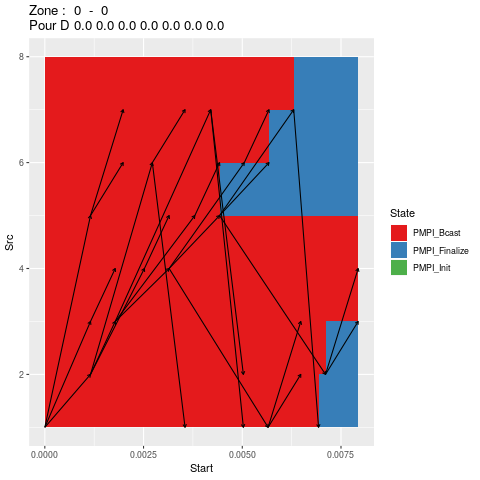

0.0035 0.0035 0.0 0.0013 0.0019 0.0025 0.0027


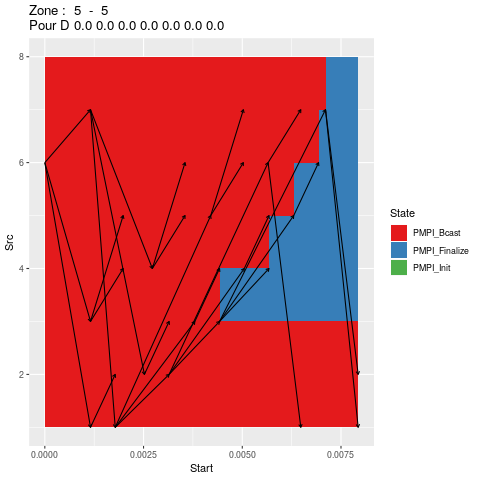

0.0044 0.0044 0.0 0.0014 0.0022 0.003 0.0036


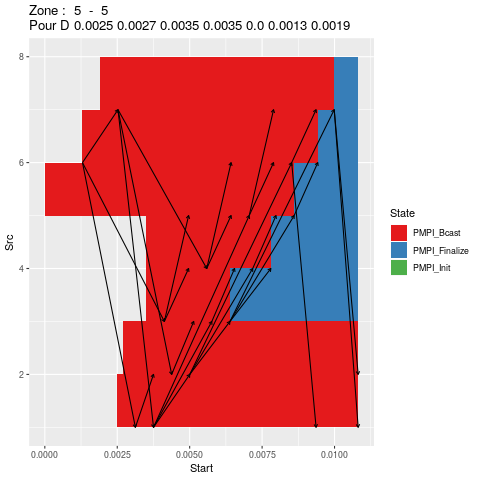

0.0 0.0013 0.0019 0.0025 0.0027 0.0035 0.0035


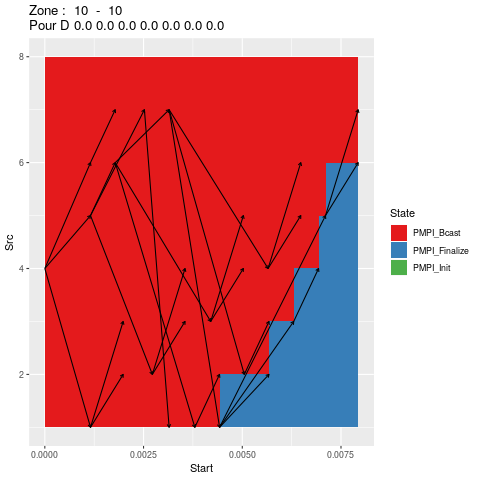

0.0 0.0014 0.0022 0.003 0.0036 0.0044 0.0044


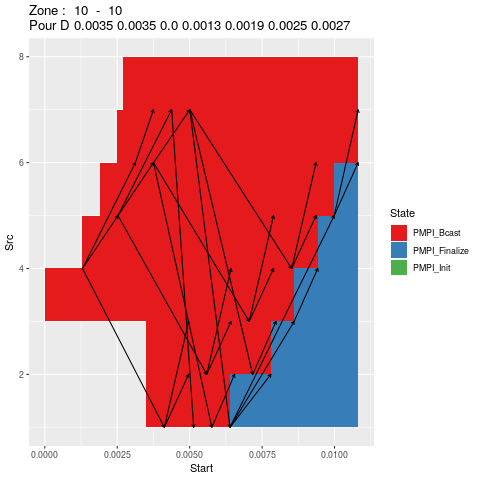

0.0 0.0015 0.0023 0.0032 0.0038 0.0046 0.0046


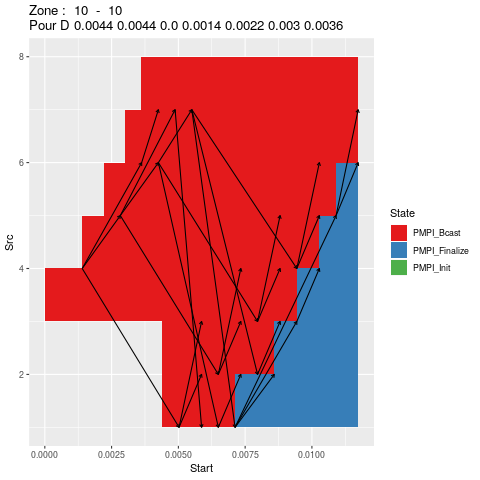

0.0019 0.0025 0.0027 0.0035 0.0035 0.0 0.0013


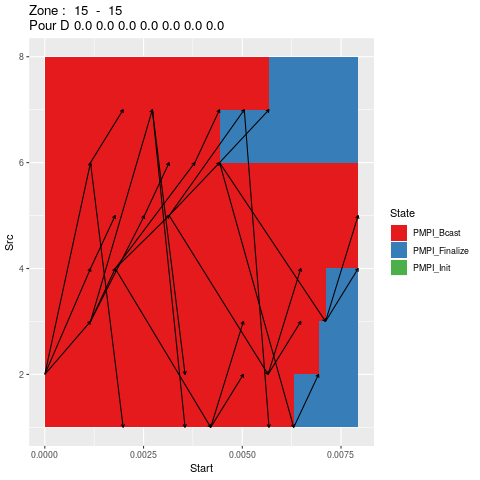

0.0022 0.003 0.0036 0.0044 0.0044 0.0 0.0014


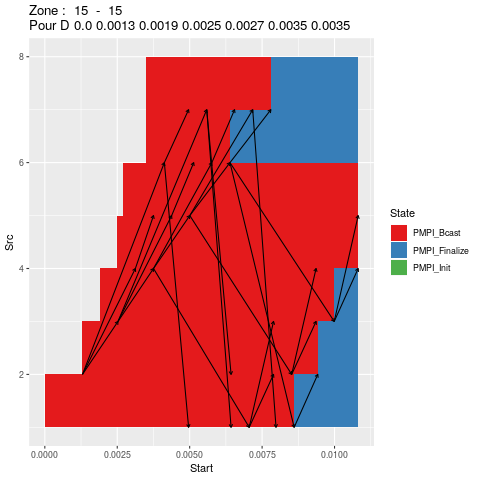

0.0023 0.0032 0.0038 0.0046 0.0046 0.0 0.0015


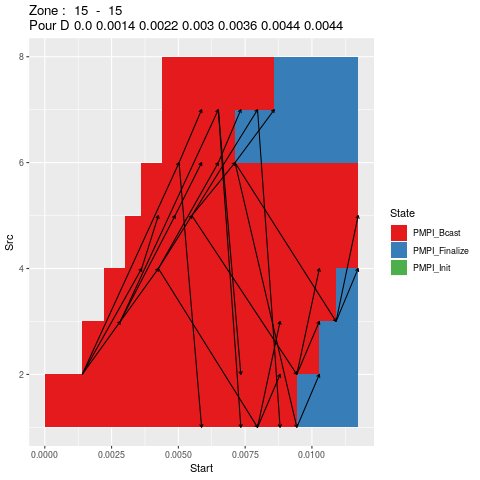

0.0036 0.0044 0.0044 0.0 0.0014 0.0022 0.003


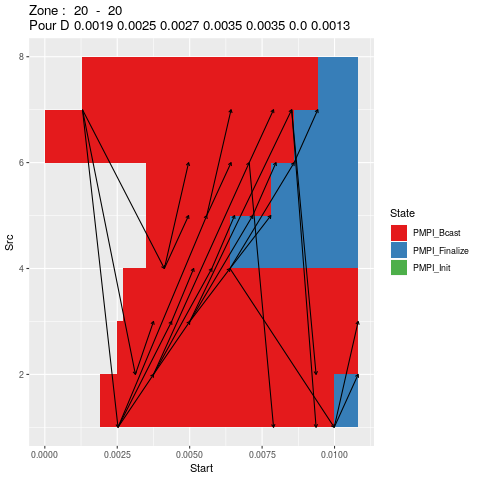

0.0038 0.0046 0.0046 0.0 0.0015 0.0023 0.0032


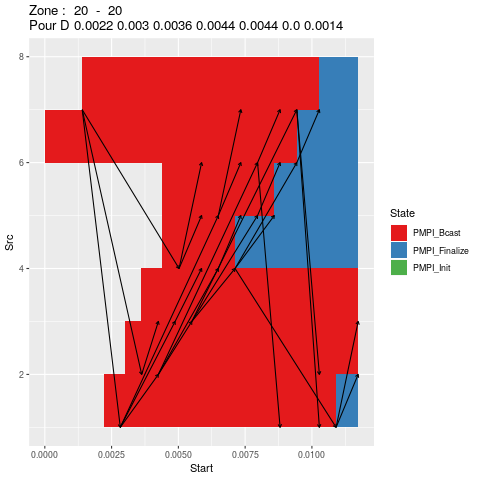

0.0046 0.0 0.0015 0.0023 0.0032 0.0038 0.0046


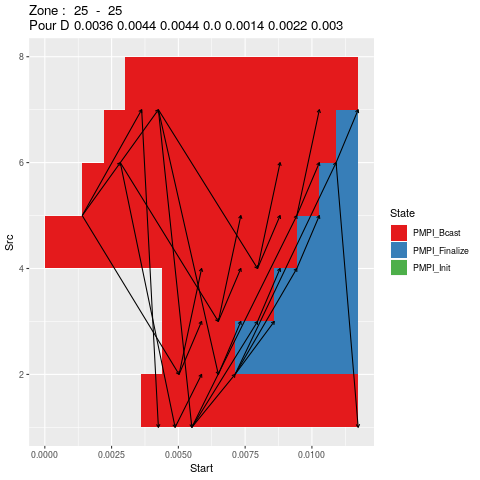

0.0015 0.0023 0.0032 0.0038 0.0046 0.0046 0.0


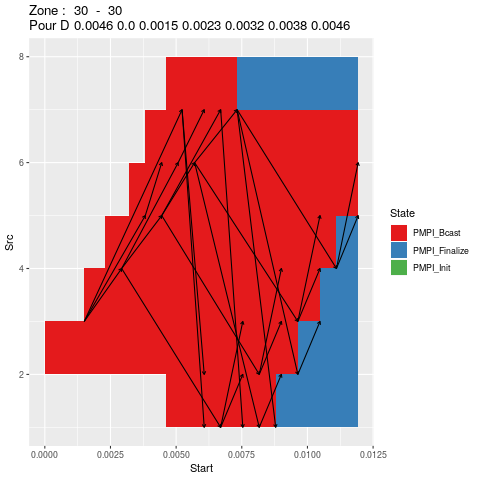

0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019


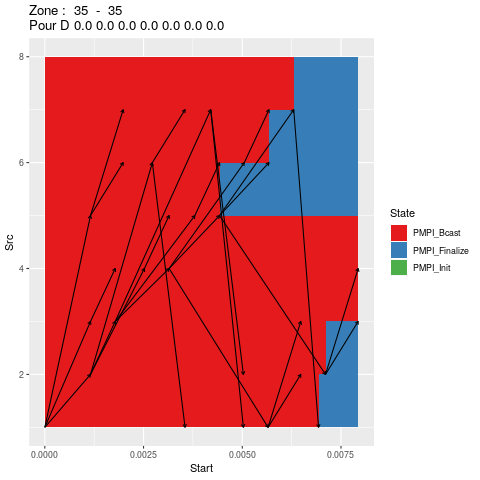

0.0032 0.0038 0.0046 0.0046 0.0 0.0015 0.0023


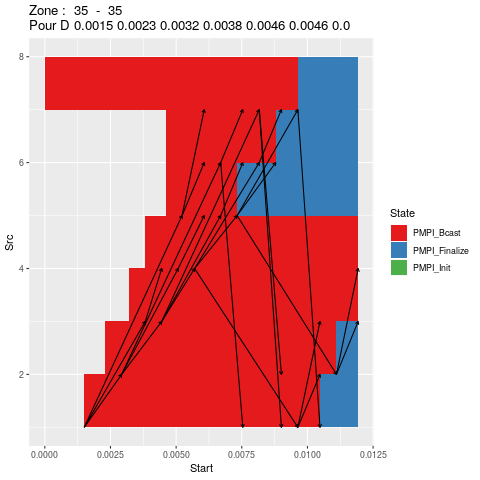

0.0035 0.0035 0.0 0.0013 0.0019 0.0025 0.0027


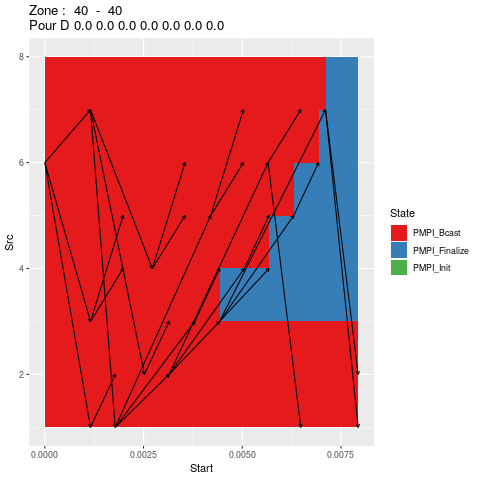

0.0044 0.0044 0.0 0.0014 0.0022 0.003 0.0036


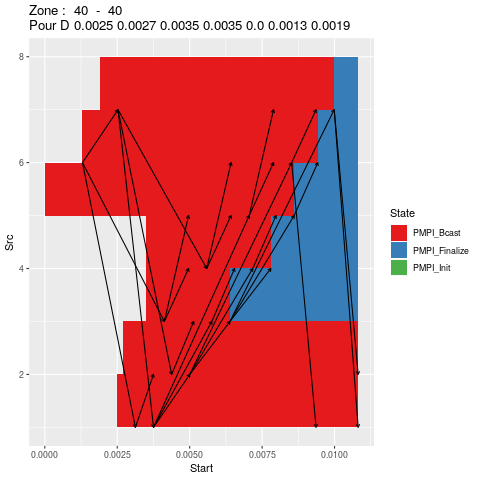

0.0046 0.0046 0.0 0.0015 0.0023 0.0032 0.0038


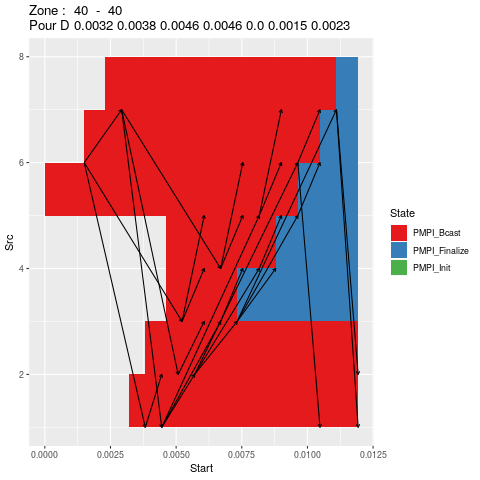

0.0 0.0013 0.0019 0.0025 0.0027 0.0035 0.0035


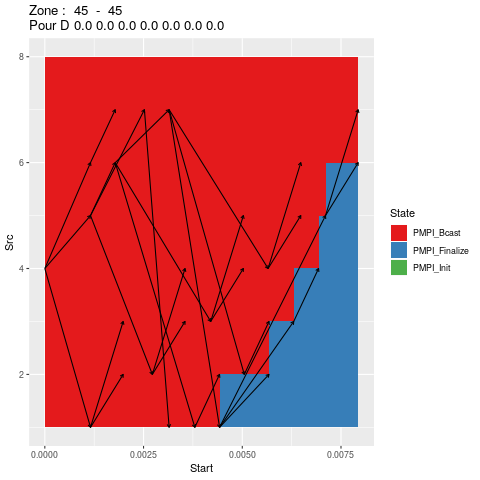

0.0 0.0014 0.0022 0.003 0.0036 0.0044 0.0044


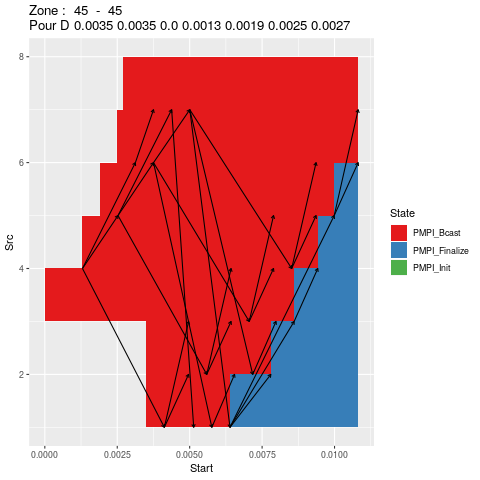

0.0 0.0015 0.0023 0.0032 0.0038 0.0046 0.0046


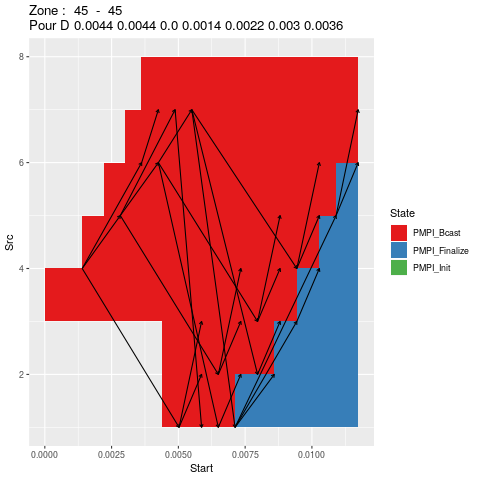

0.0022 0.003 0.0036 0.0044 0.0044 0.0 0.0014


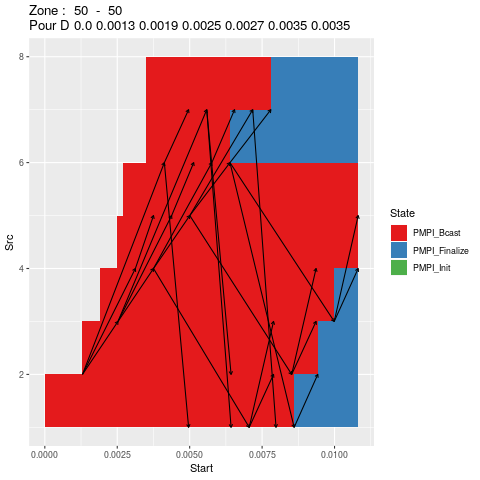

0.0023 0.0032 0.0038 0.0046 0.0046 0.0 0.0015


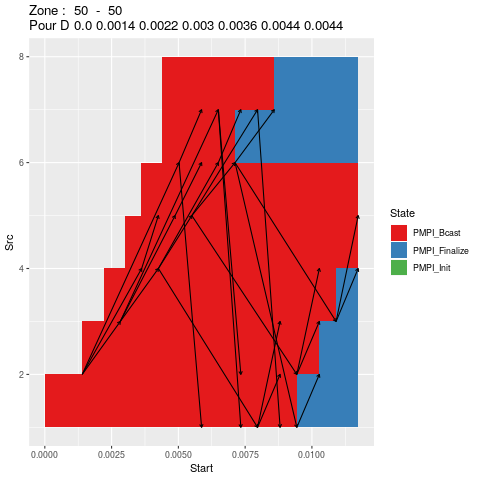

0.0038 0.0046 0.0046 0.0 0.0015 0.0023 0.0032


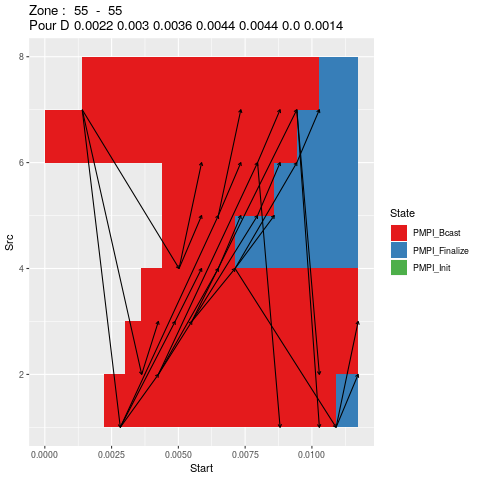

0.0046 0.0 0.0015 0.0023 0.0032 0.0038 0.0046


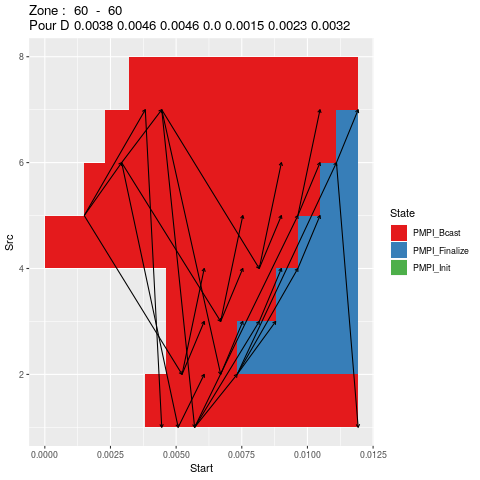

0.0013 0.0019 0.0025 0.0027 0.0035 0.0035 0.0


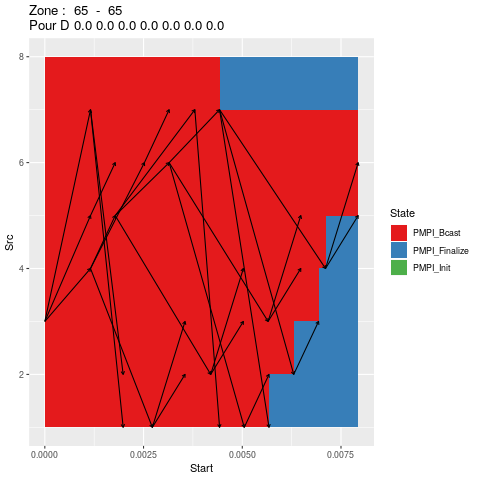

0.0015 0.0023 0.0032 0.0038 0.0046 0.0046 0.0


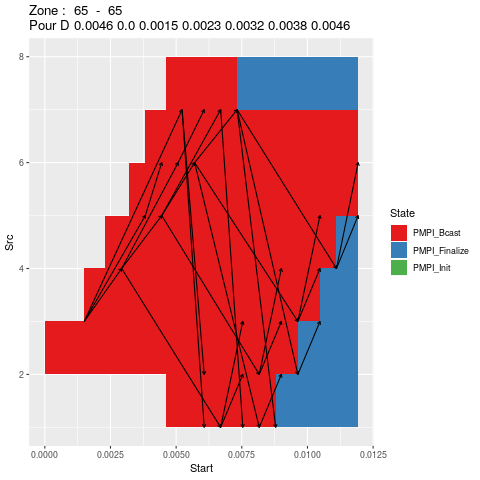

0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019


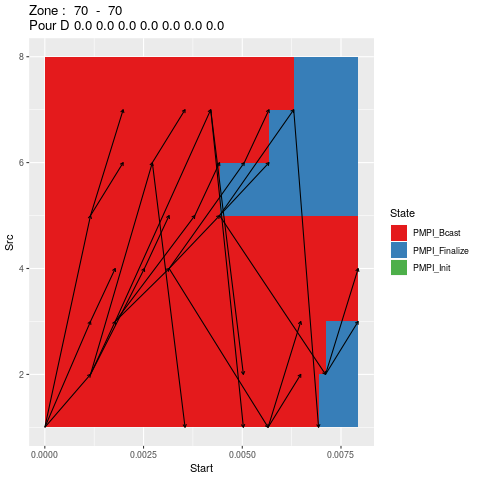

0.003 0.0036 0.0044 0.0044 0.0 0.0014 0.0022


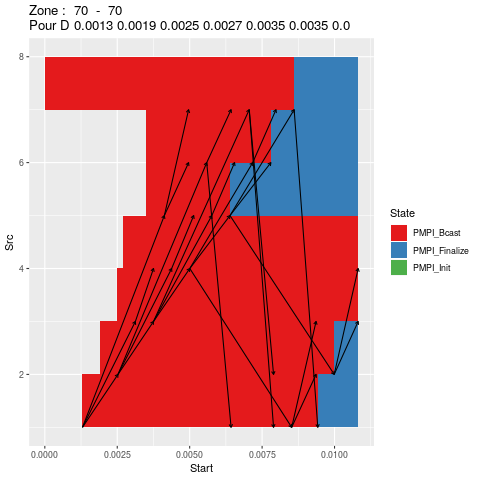

0.0032 0.0038 0.0046 0.0046 0.0 0.0015 0.0023


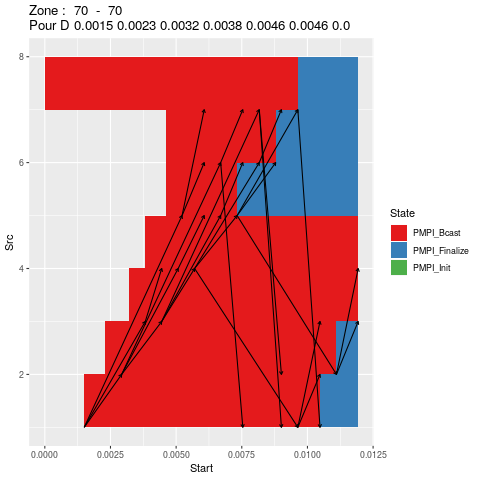

0.0035 0.0035 0.0 0.0013 0.0019 0.0025 0.0027


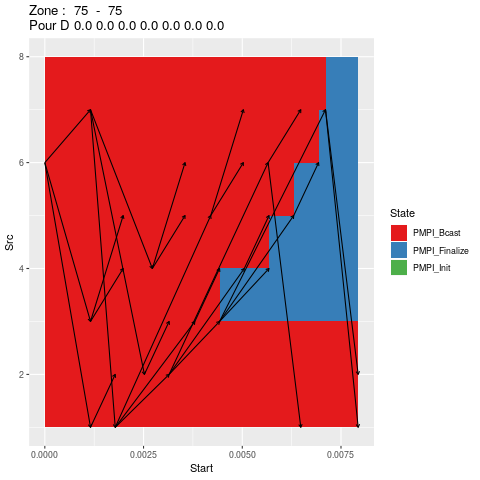

0.0044 0.0044 0.0 0.0014 0.0022 0.003 0.0036


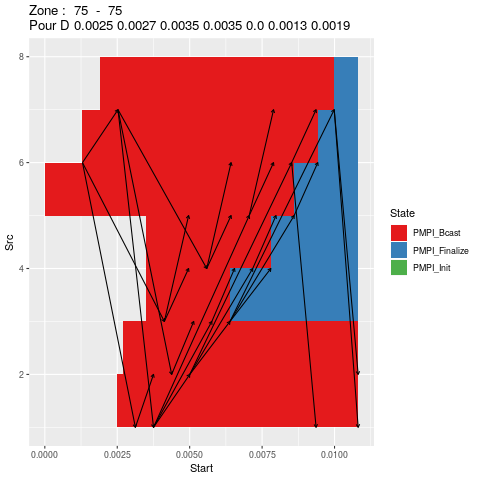

0.0046 0.0046 0.0 0.0015 0.0023 0.0032 0.0038


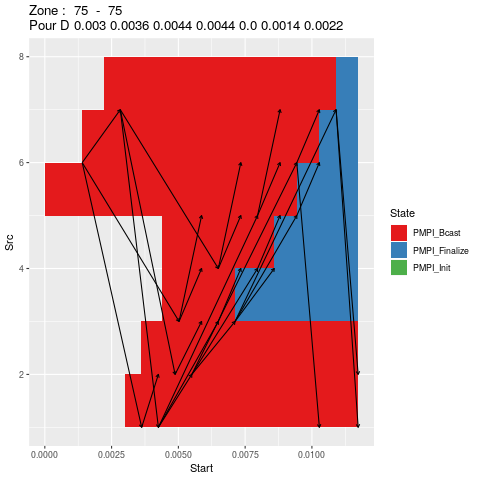

0.0 0.0014 0.0022 0.003 0.0036 0.0044 0.0044


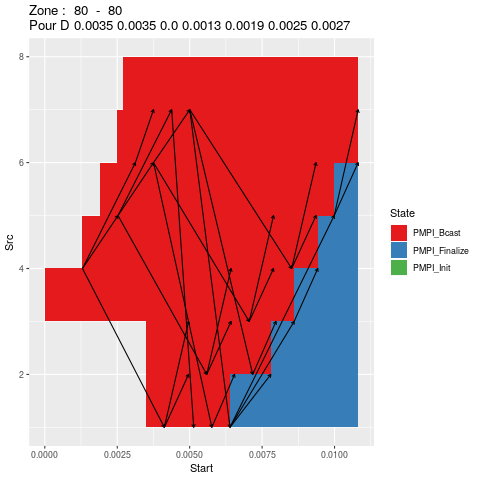

0.0 0.0015 0.0023 0.0032 0.0038 0.0046 0.0046


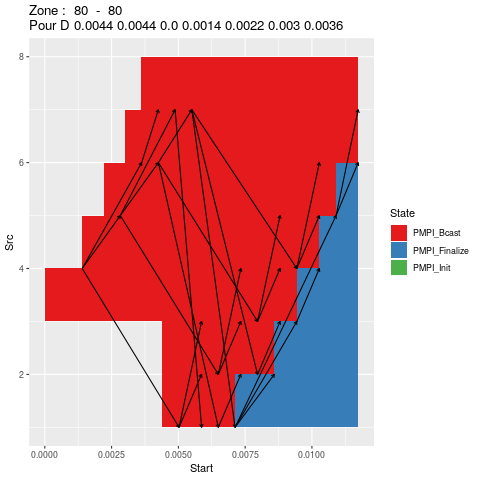

0.0023 0.0032 0.0038 0.0046 0.0046 0.0 0.0015


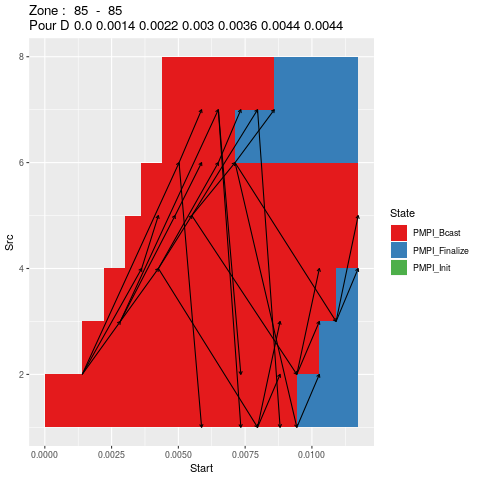

0.0038 0.0046 0.0046 0.0 0.0015 0.0023 0.0032


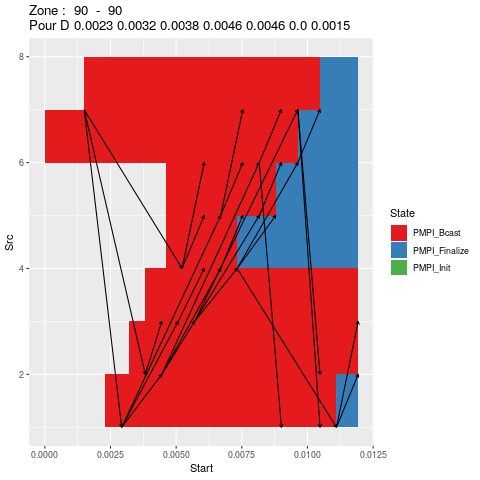

0.0035 0.0 0.0013 0.0019 0.0025 0.0027 0.0035


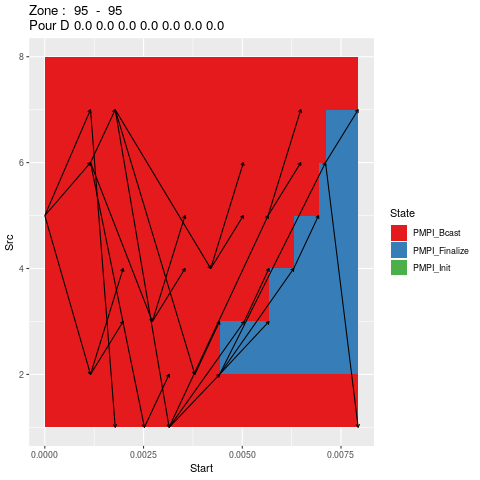

0.0046 0.0 0.0015 0.0023 0.0032 0.0038 0.0046


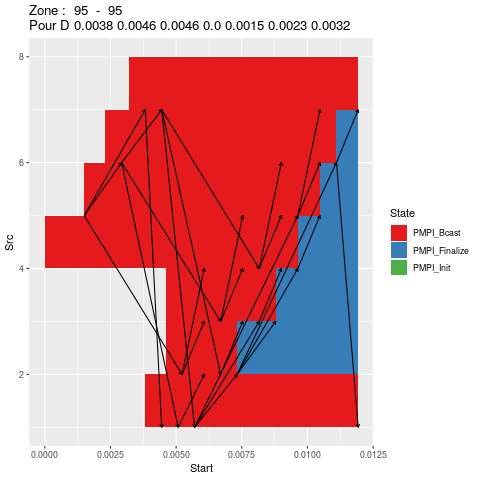

In [27]:
for MIN, value in trajectory_set.items():
    for D, traj in value.items():
        (Dprime,curr_round,q,T) = traj;
        print(Dprime)
        traj_id=get_trajectory_id(MIN=MIN,D=D)
        pj_dump(xp_id=experiment_id, traj_id=traj_id, host_id=q)
        get_csv(xp_id=experiment_id, traj_id=traj_id, host_id=q)
        draw_ggplot(path_base=get_path_local_results(xp_id=experiment_id, traj_id=traj_id),
                    D=D, MIN=MIN, MAX=MIN, merging=1, t_curr=0)

###  Visualizing all traces in the order they were computed

First a function in R to read a trace.

In [33]:
%%R

df_state = data.frame()
df_link = data.frame()

read_trajectory = function(path_base, MIN, Round) {
    df_state = read.csv(paste(path_base, "/output.state.csv",sep = ""), header = F, strip.white=T)    
    names(df_state) = c("Type", "Rank", "Container", "Start", "End", "Duration", "Level", "State"); 
    df_state = df_state[!(names(df_state) %in% c("Type","Container","Level"))]
    df_state$Rank = as.numeric(gsub("rank-","",df_state$Rank))
    df_state = df_state[df_state$State!="PMPI_Finalize",]
    
    df_link = read.csv(paste(path_base, "/output.link.csv",sep = ""), header = F, strip.white = T)
    names(df_link) = c("Type", "Level", "Container", "Start", "End", "Duration", "CommType", "Src", "Dst"); 
    df_link = df_link[!(names(df_link) %in% c("Type","Container","Level","CommType"))]
    df_link$Src = as.numeric(gsub("rank-","",df_link$Src))
    df_link$Dst = as.numeric(gsub("rank-","",df_link$Dst))
    
    df_state$MIN=MIN
    df_state$Round=Round
    df_link$MIN=MIN
    df_link$Round=Round
    
    return(list(state=df_state, link=df_link))
}

In [34]:
for MIN, value in trajectory_set.items():
    for D, traj in value.items():
        (Dprime,curr_round,q,T) = traj;
        print(Dprime)
        traj_id=get_trajectory_id(MIN=MIN,D=D)
        path_base = get_path_local_results(experiment_id, traj_id)
#        pj_dump(xp_id=experiment_id, traj_id=traj_id, host_id=q)
#        get_csv(xp_id=experiment_id, traj_id=traj_id, host_id=q)
        %R -i curr_round
        %R -i path_base
        %R -i MIN
        %R traj = read_trajectory(path_base, MIN, curr_round)
        %R df_state = rbind(df_state,traj$state)
        %R df_link = rbind(df_link,traj$link)

0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019
0.0035 0.0035 0.0 0.0013 0.0019 0.0025 0.0027
0.0044 0.0044 0.0 0.0014 0.0022 0.003 0.0036
0.0 0.0013 0.0019 0.0025 0.0027 0.0035 0.0035
0.0 0.0014 0.0022 0.003 0.0036 0.0044 0.0044
0.0 0.0015 0.0023 0.0032 0.0038 0.0046 0.0046
0.0019 0.0025 0.0027 0.0035 0.0035 0.0 0.0013
0.0022 0.003 0.0036 0.0044 0.0044 0.0 0.0014
0.0023 0.0032 0.0038 0.0046 0.0046 0.0 0.0015
0.0036 0.0044 0.0044 0.0 0.0014 0.0022 0.003
0.0038 0.0046 0.0046 0.0 0.0015 0.0023 0.0032
0.0046 0.0 0.0015 0.0023 0.0032 0.0038 0.0046
0.0015 0.0023 0.0032 0.0038 0.0046 0.0046 0.0
0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019
0.0032 0.0038 0.0046 0.0046 0.0 0.0015 0.0023
0.0035 0.0035 0.0 0.0013 0.0019 0.0025 0.0027
0.0044 0.0044 0.0 0.0014 0.0022 0.003 0.0036
0.0046 0.0046 0.0 0.0015 0.0023 0.0032 0.0038
0.0 0.0013 0.0019 0.0025 0.0027 0.0035 0.0035
0.0 0.0014 0.0022 0.003 0.0036 0.0044 0.0044
0.0 0.0015 0.0023 0.0032 0.0038 0.0046 0.0046
0.0022 0.003 0.0036 0.0044 0.0044 0.0 0.

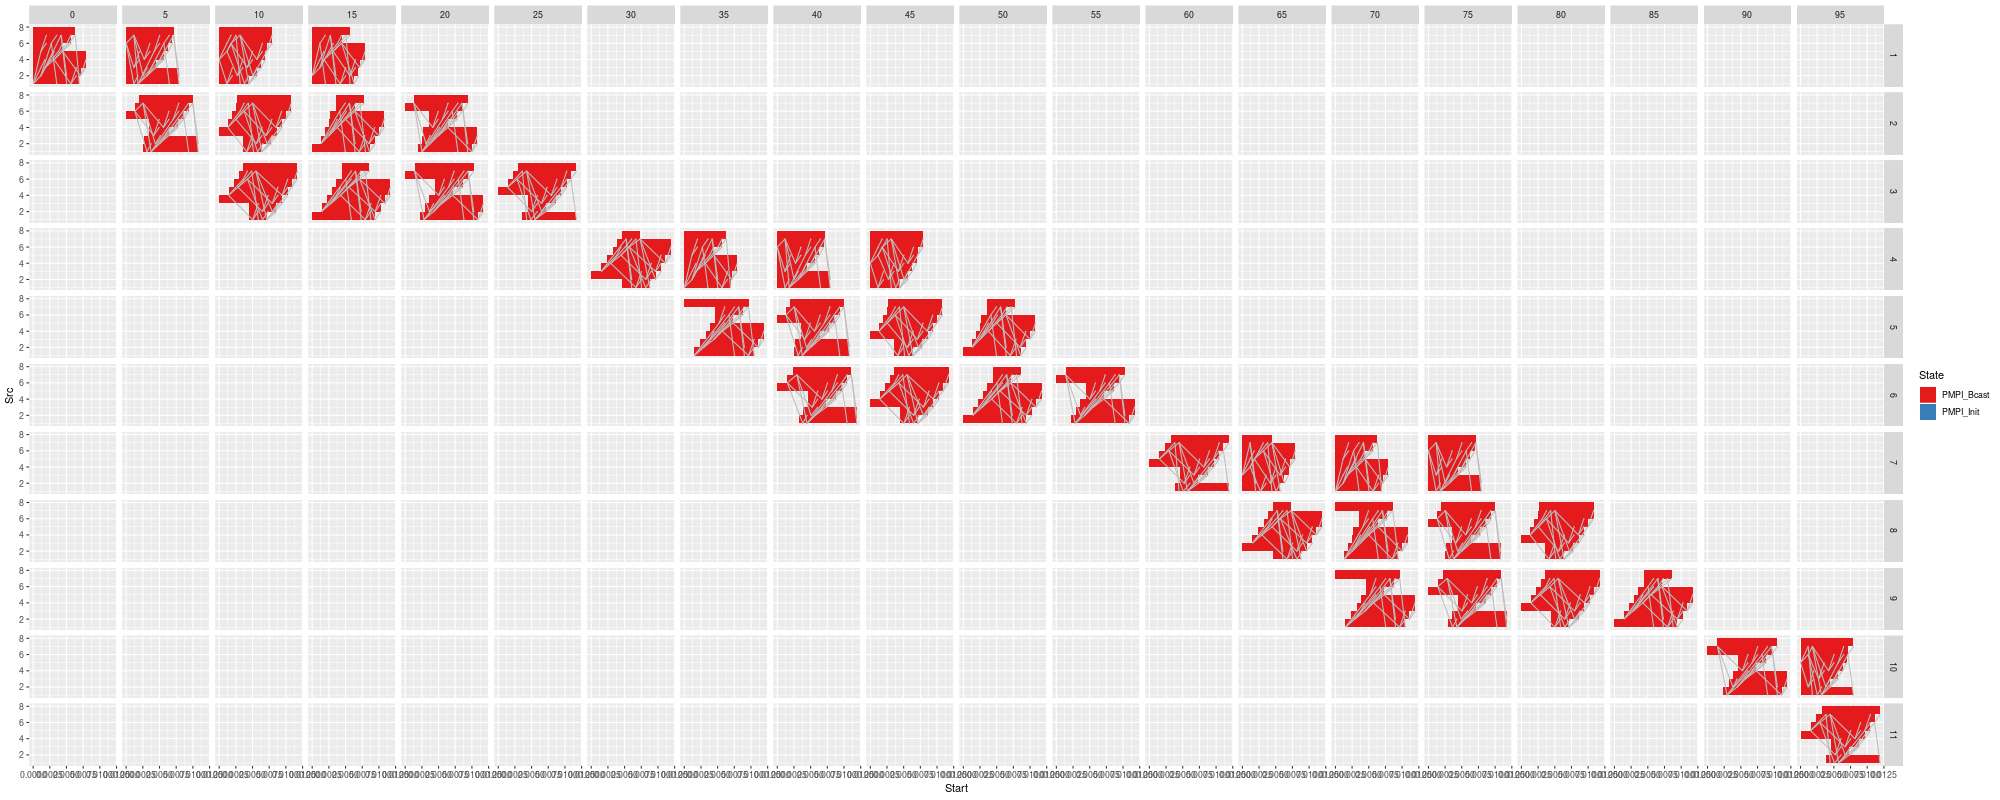

In [35]:
%%R -w 2000 -h 800 -u px

library(ggplot2)

draw_trajectories = function(df_state,df_link) {
    gc = ggplot(data=df_state) + 
            geom_rect(aes(xmin=Start, xmax=End, ymin=Rank, ymax=Rank+1,fill=State)) + 
            scale_fill_brewer(palette = palette)

    step = 0.0025
    result = gc + 
        geom_segment(data = df_link, aes(x = Start, y = Src, xend = End, yend = Dst),
                     arrow = arrow(length = unit(0.01, "npc")), color="gray") +
#        scale_x_continuous(breaks = seq(0, 0.02, by = step)) + 
        facet_grid(Round~MIN)
#        ggtitle(paste('Zone : ' , MIN, ' - ', MAX, '\nPour D', D) )
    print(result)
}
draw_trajectories(df_state,df_link)

#### Publication des résultats sur GitHub : https://github.com/HooBaeBoo/Stage-POLARIS

In [ ]:
# %%bash -s $experiment_name $site
# git add .
# git commit -m 'Automatic results update : '"$1"' --- '"$2 "' Bcast output clearer + Keep all csv + restructuration resultats + '

#### Fin d'expérience : suppression du job

In [ ]:
# oardel([(jobid,site)])

### Zone Test (à ignorer)

In [ ]:
# execo.action.Remote(cmd ='taskset -c 3 rm -r potato', 
#                     hosts = nodes, 
#                     connection_params = {'user':'root'}).run()

In [ ]:
# max_core = nodecount * max([get_host_attributes(cluster + '-1')['architecture']['nb_cores'] for cluster in clusters])